# Custom File Handler Example

This notebook shows how to create a custom file handler to write the Narrowband and Wideband datasets in a different format. For this example, we will show how to write data as a PNG image.

---

The `DatasetCreator` and any `StaticDatasets` use a `TorchSigFileHandler` to write and read data, respectively. By default, they both use the `ZarrFileHandler` class. But if you want the dataset to be written and read differently, you can create a subclass of `TorchSigFileHandler`. 


---

There are 3 functions you are required to implement:
```
# writes a batch of data to disk
def write(self, batch_idx: int, batch: Any) -> None:

# determines size of dataset on disk
@staticmethod
def size(dataset_path: str) -> int:

# loads idx into memory
@staticmethod
def static_load(filename:str, idx: int) -> Tuple[np.ndarray, List[Dict[str, Any]]]:

```

You can override these functions as needed:
```
# any pre-requisite set up before the file handler writers
def _setup(self) -> None:

# any post processes to run after all the data is writtern to disk
def teardown(self) -> None:

# determine if a dataset exists on disk
def exists(self) -> bool:
```

In [11]:
from torchsig.utils.file_handlers.base_handler import TorchSigFileHandler
from torchsig.datasets.dataset_metadata import DatasetMetadata

import cv2
import numpy as np

import os
from typing import List, Any, Tuple, Dict
import pickle


class ImageFileHandler(TorchSigFileHandler):

    file_ext = ".png"

    def __init__(
        self,
        root: str,
        dataset_metadata: DatasetMetadata,
        train: bool = None,
    ):
        super().__init__(
            root = root,
            dataset_metadata = dataset_metadata,
            train = train,
        )

        # define a colormap for the image
        self.colormap = cv2.COLORMAP_HOT

    def _setup(self) -> None:
        # create images and targets folder
        os.makedirs(f"{self.root}/images", exist_ok=True)
        os.makedirs(f"{self.root}/targets", exist_ok=True)

    def exists(self) -> bool:
        # checks images/ and targets/ folders are created
        # and not empty
        images_path =f"{self.root}/images"
        targets_path = f"{self.root}/targets"

        images_exist = os.path.exists(images_path) and len(os.listdir(images_path)) > 0
        targets_exist = os.path.exists(targets_path) and len(os.listdir(targets_path)) > 0

        return images_exist and targets_exist

    @staticmethod
    def size(dataset_path: str) -> int:
        # given path to dataset on disk
        # return dataset size
        # return how many files in images/ or targets (min)
        images_path =f"{dataset_path}/images"
        targets_path = f"{dataset_path}/targets"

        num_images = len(os.listdir(images_path))
        num_targets = len(os.listdir(targets_path))

        return min(num_images, num_targets)

    def write(self, batch_idx: int, batch: Any) -> None:
        # writes a batch from dataset's __getitem__
        start_idx = batch_idx * len(batch[0])
        stop_idx = start_idx + len(batch[0])

        data, targets = batch
        
        for i,(d,t) in enumerate(zip(data, targets)):
            # convert data (H,W) `-> (H,W,3) with 3 channels RGB
            # first normalize data from (0-255)
            mi = d.min()
            ma = d.max()

            d = ((d - mi) / (ma - mi)) * 255
            # convert to ints
            d = d.astype(np.uint8)

            # apply colormap
            if self.colormap:
                d = cv2.applyColorMap(d, self.colormap)
            
            self._write_image(d, start_idx+i)
            self._write_targets(t, start_idx+i)

    @staticmethod
    def static_load(filename:str, idx: int) -> Tuple[np.ndarray, List[Dict[str, Any]]]:
        # loads sample `idx` from `filename` into memory
        # method can be used without instantiating class
        # used for just reading
        image = cv2.imread(f"{filename}/images/{idx}{ImageFileHandler.file_ext}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        with open(f"{filename}/targets/{idx}.pkl", 'rb') as f:
            targets = pickle.load(f)
        
        return image, targets

    # Helper Functions

    def _write_image(self, data: np.ndarray, idx: int) -> None:
        # convert from RGB to BGR
        # data = cv2.cvtColor(data, cv2.COLOR_RGB2BGR)
        filename = f"{self.root}/images/{idx}{self.file_ext}"
        cv2.imwrite(filename, data)

    def _write_targets(self, targets: Any, idx: int) -> None:
        # pickle targets
        filename = f"{self.root}/targets/{idx}.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(targets, f)

In [13]:
# Use this file handler
from torchsig.datasets.dataset_metadata import NarrowbandMetadata
from torchsig.datasets.narrowband import NewNarrowband, StaticNarrowband
from torchsig.utils.writer import DatasetCreator
from torchsig.signals.signal_lists import TorchSigSignalLists
from torchsig.transforms.dataset_transforms import Spectrogram
from torchsig.transforms.target_transforms import ClassName

root = "./datasets/filehandler_example"
fft_size = 512
num_iq_samples_dataset = fft_size ** 2
impairment_level = 0
num_samples = 10

transforms = [Spectrogram(fft_size=fft_size)]
target_transforms = [ClassName()]

md = NarrowbandMetadata(
    num_iq_samples_dataset=num_iq_samples_dataset,
    fft_size=fft_size,
    impairment_level=impairment_level,
    num_samples=num_samples,
    transforms=transforms,
    target_transforms=target_transforms,
)
dc = DatasetCreator(
    dataset=NewNarrowband(dataset_metadata=md),
    root=root,
    overwrite=True,
    # use our custom file handler class
    file_handler=ImageFileHandler,
    multithreading=True
) 
dc.create()

s = StaticNarrowband(
    root=root,
    impairment_level=impairment_level,
    # be sure to use the same class that was written to disk
    file_handler_class=ImageFileHandler
)

data, targets = s[0]
print(f"\nData: {data.shape} ({type(data)})")
print(f"Targets: {targets}")









100%|██████████| 10/10 [00:01<00:00,  7.86it/s]
Generating Narrowband, dataset remaining to create = 0.0 GB, remaining disk = 135227.64 GB: : 0it [00:01, ?it/s]


Data: (512, 512, 3) (<class 'numpy.ndarray'>)
Targets: 16fsk


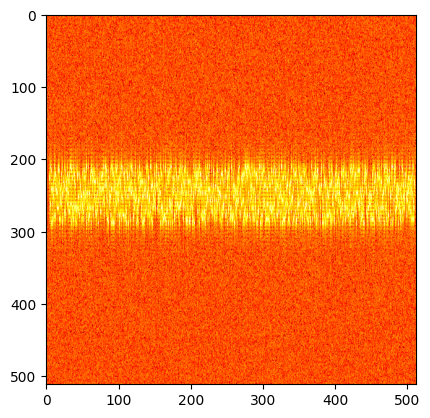

In [14]:
# We can plot the data as an RGB image

import matplotlib.pyplot as plt

plt.imshow(data)